In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from modules.models import create_dense_model, KleinGordonEquation
from modules.data import simulate_klein_gordon
from modules.plots import plot_training_loss, plot_pointwise_error_mesh
from modules.utils import PrintLossCallback

2023-03-15 14:43:30.965188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 14:43:31.084760: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 14:43:31.611600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/lib/:/home/nimahsn-wsl/anaconda3/env

In [2]:
def f_u_exact(tx):
    """Exact solution of the Klein-Gordon equation."""
    return tx[:, 1:2] * tf.cos(5 * np.pi * tx[:, 0:1]) + (tx[:, 0:1] * tx[:, 1:2]) ** 3

def rhs(tx_colloc):
    """Right-hand side of the Klein-Gordon equation."""
    with tf.GradientTape(watch_accessed_variables=False) as tape2:
        tape2.watch(tx_colloc)
        
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(tx_colloc)
            u_colloc = f_u_exact(tx_colloc)
        first_order = tape.batch_jacobian(u_colloc, tx_colloc)
    second_order = tape2.batch_jacobian(first_order, tx_colloc)
    u_tt = second_order[..., 0, 0]
    u_xx = second_order[..., 1, 1]
    return u_tt + -1.0 * u_xx + 1.0 * (u_colloc ** 3)

In [3]:
t = tf.linspace(0.0, 1.0, 100)
x = tf.linspace(0.0, 1.0, 100)
T, X = tf.meshgrid(t, x)
tx = tf.stack([tf.reshape(T, [-1]), tf.reshape(X, [-1])], axis=1)
u = f_u_exact(tx)
U = tf.reshape(u, tf.shape(T))

2023-03-15 14:43:33.261557: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: UNKNOWN ERROR (100)
2023-03-15 14:43:33.261612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nimahsn): /proc/driver/nvidia/version does not exist
2023-03-15 14:43:33.262436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


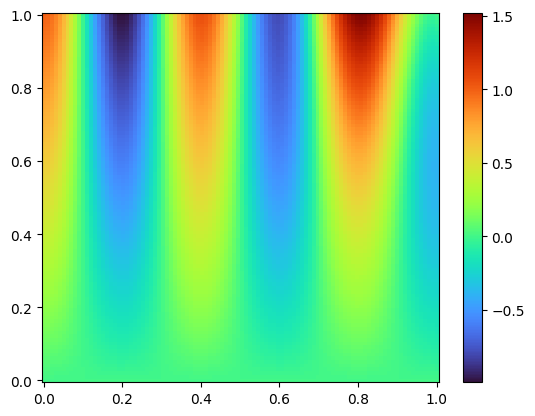

In [4]:
plt.pcolormesh(T, X, U, cmap='turbo', shading='auto')
plt.colorbar()

In [5]:
(tx_colloc, y_res), (tx_init, u_init, ut_init), (tx_bnd, u_bnd) = simulate_klein_gordon(
    n_colloc=200, n_init=200, n_bnd=200, rhs_function=rhs, bnd_function=f_u_exact)
inputs = [tx_colloc, tx_init, tx_bnd]
outputs = [f_u_exact(tx_colloc), y_res, u_init, ut_init, u_bnd]

In [6]:
backbone = create_dense_model([1000, 1000], n_inputs=2, n_outputs=1, activation='tanh', initializer='glorot_normal')
model = KleinGordonEquation(backbone)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.975)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
model.compile(optimizer=optimizer)
cb = [PrintLossCallback(2000)]
history = model.fit(inputs, outputs, epochs=20000, batch_size=100, verbose=0, callbacks=cb, shuffle=True)

2023-03-15 02:23:06.778584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-15 02:23:06.794718: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2c24f5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-15 02:23:06.794755: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-03-15 02:23:06.810225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-15 02:23:07.029447: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch: 000000, Lr: 9606.23828, Li: 0.96610, Lb: 0.57002, MAE: 0.56112
Epoch: 002000, Lr: 14.23661, Li: 20.19450, Lb: 12.31026, MAE: 3.17984
Epoch: 004000, Lr: 31.11566, Li: 0.10855, Lb: 0.09418, MAE: 0.47870
Epoch: 006000, Lr: 0.17119, Li: 0.03045, Lb: 0.06222, MAE: 0.43114
Epoch: 008000, Lr: 0.23859, Li: 0.02300, Lb: 0.03722, MAE: 0.35841
Epoch: 010000, Lr: 0.15357, Li: 0.01898, Lb: 0.03233, MAE: 0.35746
Epoch: 012000, Lr: 0.05256, Li: 0.01718, Lb: 0.02865, MAE: 0.32865
Epoch: 014000, Lr: 0.30093, Li: 0.02025, Lb: 0.02390, MAE: 0.31094
Epoch: 016000, Lr: 0.04161, Li: 0.01629, Lb: 0.02061, MAE: 0.32592
Epoch: 018000, Lr: 0.15229, Li: 0.01540, Lb: 0.01756, MAE: 0.32364


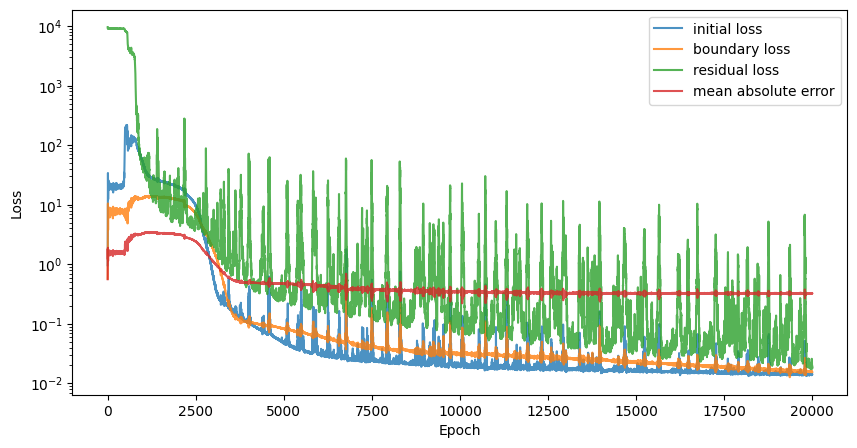

In [10]:
plot_training_loss(history.history, y_scale='log')

In [11]:
u_test = backbone.predict(tx)

313/313 [==============================] - 0s 1ms/step


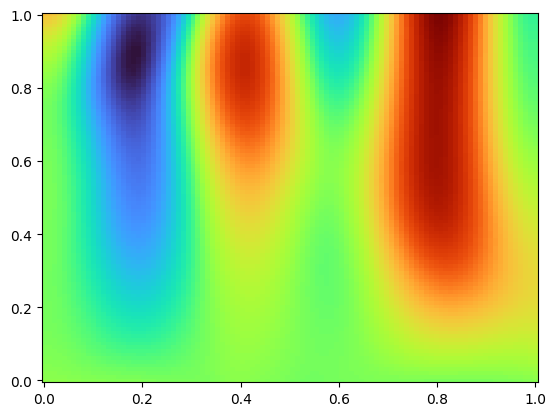

In [12]:
plt.pcolormesh(T, X, tf.reshape(u_test, tf.shape(T)), cmap='turbo', shading='auto')

313/313 [==============================] - 0s 1ms/step


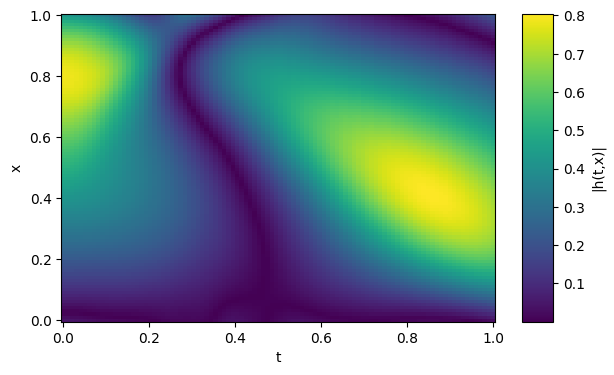

In [13]:
u_test = backbone.predict(tx)
plot_pointwise_error_mesh(u, u_test, T, X)